# Overall properties of the icrf250 subset

This notebook is to look at the properties of the 250 common sources between gaiadr2.aux_iers_gdr2_cross_id and ICRF3 303 defining sources.

These properties include:

- All-sky distibution
- Radio-optical distance
- Global difference from positional difference wrt. ICRF3
- Systematics from proper motions

In [1]:
from astropy.table import Table, join, Column
from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import numpy as np
from numpy import cos, deg2rad, sqrt, pi
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read ICRF3 S/X catalog
from my_progs.catalog.read_icrf import read_icrf3
icrf3 = read_icrf3(wv="sx")

# Read Gaia DR2 IERS quasar data
from my_progs.catalog.read_gaia import read_dr2_iers

gaiadr2 = read_dr2_iers()

# Cross-match these two catalogs
comsou = join(gaiadr2, icrf3, keys="iers_name", table_names=["i", "g"])

# Find the ICRF3 defining sources
mask = comsou["type"] == "D"
defsou = comsou[mask]

In [3]:
defsou.write("../logs/def250.list", format="ascii.csv",
             include_names=["iers_name"],
             overwrite=True)

## 1. All-sky distribution

Radio sources in this subset seem to distribute uniformly in the sky.

No clear gap in south or north.

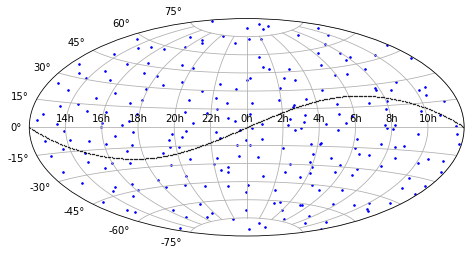

In [4]:
# Transform the coordinate into an astropy.coordinate.SkyCoord object
coord = SkyCoord(ra=defsou["ra_i"], dec=defsou["dec_i"])

# The mid-point of skyplot will be 0
ra_rad = coord.ra.wrap_at(180 * u.deg).radian
dec_rad = coord.dec.radian

# Plot the formal error distribution of opa and Gaia DR2
fig = plt.figure(figsize=(8, 4))
ax = plt.subplot(111, projection="aitoff")

# galactic plane
lon = np.arange(720)
lat = np.zeros_like(lon)
coord_ecl = SkyCoord(lon=lon*u.deg, lat=lat*u.deg,
                     frame="barycentrictrueecliptic")

# The mid-point of skyplot will be 0
ra_rad_ecl = coord_ecl.icrs.ra.wrap_at(180 * u.deg).radian
dec_rad_ecl = coord_ecl.icrs.dec.radian
ax.plot(ra_rad_ecl, dec_rad_ecl, "k.", ms=0.5)

# Source distribution
sc = ax.scatter(ra_rad, dec_rad, marker=".", s=10, color="b")

ax.set_xticks(np.arange(-5./6 * pi, pi, pi/6))
ax.set_xticklabels(["14h", "16h", "18h", "20h", "22h",
                     "0h", "2h", "4h", "6h", "8h", "10h"])

ax.grid()
plt.savefig("../plots/gcrf250-allsky-dist.eps")

## 2. Positional difference wrt. the ICRF3 S/X

The bulk of sources locates in the area of $1\le X \le 10$, $0.1\,mas\le \rho \le 1\,mas$.

Some sources with $X \ge 10$ and $\rho \ge 1\,mas$ should be paid attention to.


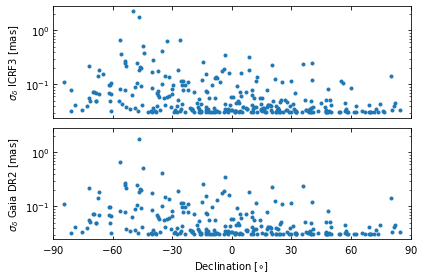

In [5]:
maskdef = icrf3["type"] == "D"
icrf3def = icrf3[maskdef]

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, sharey=True)

ax0.plot(icrf3def["dec"], icrf3def["dec_err"], ".")
ax1.plot(defsou["dec_g"], defsou["dec_err_g"], ".")

ax0.set_xlim([-90, 90])
ax0.set_xticks(np.arange(-90, 91, 30))
ax0.set_ylabel("$\sigma_\delta$ ICRF3 [mas]")
ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax0.set_yscale("log")

ax1.set_xlabel("Declination [$\circ$]")
ax1.set_ylabel("$\sigma_\delta$ Gaia DR2 [mas]")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")
ax1.set_yscale("log")

plt.tight_layout()

plt.savefig("../plots/dec_err_250.eps")

In [6]:
from my_progs.catalog.pos_diff import pos_diff_calc

[dra, ddec, draerr, ddecerr, draddeccov, angsep, Xra, Xdec,
 X] = pos_diff_calc(defsou["ra_i"], defsou["ra_err_i"],
                    defsou["dec_i"], defsou["dec_err_i"],
                    defsou["ra_dec_corr_i"], defsou["ra_g"],
                    defsou["ra_err_g"], defsou["dec_g"],
                    defsou["dec_err_g"], defsou["ra_dec_corr_g"])

defsou.add_columns(
    [dra, ddec, draerr, ddecerr, draddeccov, angsep, Xra, Xdec, X],
    names=[
        "dra", "ddec", "dra_err", "ddec_err", "dra_ddec_cov", "ang_sep",
        "nor_dra", "nor_ddec", "nor_sep"
    ])

defsou["dra"].unit = u.mas
defsou["ddec"].unit = u.mas
defsou["dra_err"].unit = u.mas

In [24]:
X0 = np.sqrt(2 * np.log(len(X)))
print("Critical value of X", X0)

x1 = len(X[X >= X0])
print("Outlier rate {:.1f}%".format(x1/len(X)*100.0))

Critical value of X 3.32308920068729
Outlier rate 22.4%


Critical value of X 3.32308920068729


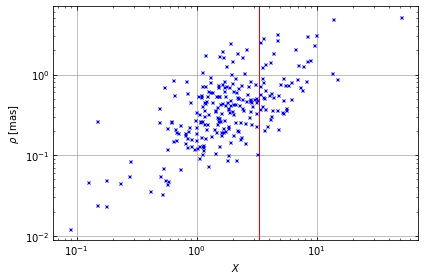

In [16]:
# Angular position difference vs. positional uncertainty
fig, ax = plt.subplots()

ax.plot(X, angsep, "bx", ms=3)
ax.vlines(X0, 0.009, 7, "r", lw=1)

ax.set_ylim(0.009, 7)
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("$X$")
ax.set_ylabel("$\\rho$ [mas]")

ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")

ax.grid()

fig.tight_layout()

plt.savefig("../plots/gcrf250-separation.eps")
plt.savefig("../plots/gcrf250-separation.png")

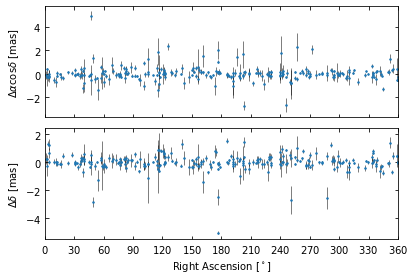

In [8]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)

ax0.errorbar(defsou["ra_i"], defsou["dra"], yerr=defsou["dra_err"],
             fmt=".", elinewidth=0.5, ecolor="k", ms=3)
ax1.errorbar(defsou["ra_i"], defsou["ddec"], yerr=defsou["ddec_err"],
             fmt=".", elinewidth=0.5, ecolor="k", ms=3)

ax0.set_xlim([0, 360])
ax0.set_xticks(np.arange(0, 361, 30))
ax0.set_ylabel("$\Delta\\alpha\cos\delta$ [mas]")
ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")

ax1.set_xlabel("Right Ascension [$^\circ$]")
ax1.set_ylabel("$\Delta\delta$ [mas]")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

plt.tight_layout()

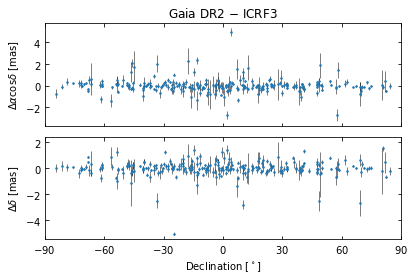

In [9]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)

ax0.errorbar(defsou["dec_i"], defsou["dra"], yerr=defsou["dra_err"],
             fmt=".", elinewidth=0.5, ecolor="k", ms=3)
ax1.errorbar(defsou["dec_i"], defsou["ddec"], yerr=defsou["ddec_err"],
             fmt=".", elinewidth=0.5, ecolor="k", ms=3)

ax0.set_xlim([-90, 90])
ax0.set_xticks(np.arange(-90, 91, 30))
ax0.set_ylabel("$\Delta\\alpha\cos\delta$ [mas]")
ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")

ax1.set_xlabel("Declination [$^\circ$]")
ax1.set_ylabel("$\Delta\delta$ [mas]")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

ax0.set_title("Gaia DR2 $-$ ICRF3")

plt.tight_layout()

plt.savefig("../plots/gcrf250-pos-diff.eps")

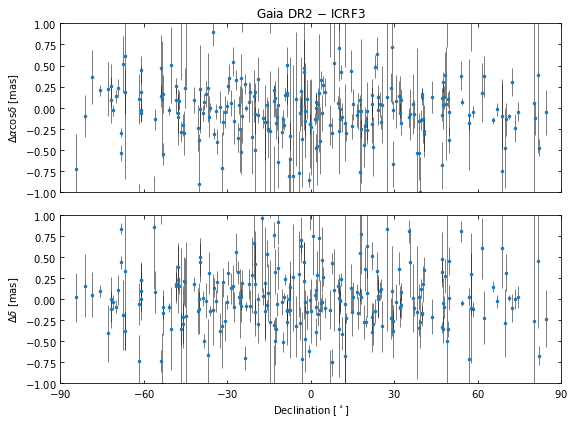

In [22]:
fig, (ax0, ax1) = plt.subplots(figsize=(8,6), nrows=2, sharex=True)

ax0.errorbar(defsou["dec_i"], defsou["dra"], yerr=defsou["dra_err"],
             fmt=".", elinewidth=0.5, ecolor="k", ms=5)
ax1.errorbar(defsou["dec_i"], defsou["ddec"], yerr=defsou["ddec_err"],
             fmt=".", elinewidth=0.5, ecolor="k", ms=5)

ax0.set_xlim([-90, 90])
ax0.set_ylim([-1, 1])
ax1.set_ylim([-1, 1])
ax0.set_xticks(np.arange(-90, 91, 30))
ax0.set_ylabel("$\Delta\\alpha\cos\delta$ [mas]")
ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")

ax1.set_xlabel("Declination [$^\circ$]")
ax1.set_ylabel("$\Delta\delta$ [mas]")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

ax0.set_title("Gaia DR2 $-$ ICRF3")

plt.tight_layout()
plt.savefig("../plots/gcrf250-pos-diff-large.png")

## 3. Global difference modeled by the VSH

The orientation and glide between this subset and ICRF3 S/X is very large, $\sim 80\,\mu as$ and $60\,\mu as$,
which is significately greater than using all 2820 sources.

This is a big problem.

In [10]:
# My modules
from my_progs.catalog.vsh_deg1_cor import vsh_deg01_fitting

# Gaia DR2 - ICRF3 S/X
rarad = np.deg2rad(np.array(defsou["ra_g"]))
decrad = np.deg2rad(np.array(defsou["dec_g"]))

# Transformation parameters
# l_max = 2
par, sig, _, _, _, _ = vsh_deg01_fitting(
    dra, ddec, rarad, decrad, draerr, ddecerr,
    cov=draddeccov, elim_flag="None")

# mas -> uas
par = par * 1.e3
sig = sig * 1.e3

# Print results
print("Positional difference (Gaia DR2 - ICRF3 S/X)")
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "            Rotation [uas]                   "
      "            Glide [uas]               \n"
      "     x             y             z         "
      "     x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "%+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f   "
      "%+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra.size,
       par[3], sig[3], par[4], sig[4], par[5], sig[5],
       par[0], sig[0], par[1], sig[1], par[2], sig[2]))

ValueError: not enough values to unpack (expected 6, got 3)

## 4. Global systematics in proper motion system

The spin from the proper motions is on the same order of its formal error, 
while a significate glide term in the Z-axis is found.

In [ ]:
# Proper motions
pmra = np.array(defsou["pmra"])
pmdec = np.array(defsou["pmdec"])
pmraerr = np.array(defsou["pmra_err"])
pmdecerr = np.array(defsou["pmdec_err"])
pmradeccov = np.array(defsou["pmra_err"] * defsou["pmdec_err"] * defsou["pmra_pmdec_corr"])

# Transformation parameters
# l_max = 2
par, sig, _, _, _, _ = vsh_deg01_fitting(
    pmra, pmdec, rarad, decrad, pmraerr, pmdecerr,
    cov=pmradeccov, elim_flag="None")

# mas -> uas
spin = par * 1.e3
serr = sig * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "------------------------------------------  "
      "------------------------------------------\n"
      "            Rotation [uas/yr]              "
      "            Glide [uas/yr]               \n"
      "     x             y             z         "
      "     x             y             z\n"
      "------------------------------------------  "
      "------------------------------------------\n"
      "%+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f   "
      "%+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "------------------------------------------  "
      "------------------------------------------\n" %
      (pmra.size,
       spin[3], serr[3], spin[4], serr[4], spin[5], serr[5],
       spin[0], serr[0], spin[1], serr[1], spin[2], serr[2]))